<a href="https://colab.research.google.com/github/nnson0511/LDA-on-Spark/blob/main/LDA_on_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
from gensim import corpora
from gensim.models.ldamodel import LdaModel

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Tiền xử lý dữ liệu

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DP_DataMining/abcnews-date-text.csv')
df

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers
...,...,...
1244179,20211231,two aged care residents die as state records 2...
1244180,20211231,victoria records 5;919 new cases and seven deaths
1244181,20211231,wa delays adopting new close contact definition
1244182,20211231,western ringtail possums found badly dehydrate...


In [ ]:
def tokenize_text(text):
    # Chuyển đổi văn bản thành chữ thường
    text = text.lower()
    # Loại bỏ dấu câu và ký tự đặc biệt
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Tokenize văn bản
    tokens = word_tokenize(text)
    # Loại bỏ stopwords và dấu câu
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    # Lemmatization (Steming)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    return tokens


In [ ]:
df['tokens'] = df['headline_text'].apply(tokenize_text)
df

,publish_date,headline_text,tokens
0,20030219,aba decides against community broadcasting lic...,"[aba, decid, commun, broadcast, licenc]"
1,20030219,act fire witnesses must be aware of defamation,"[act, fire, wit, must, awar, defam]"
2,20030219,a g calls for infrastructure protection summit,"[g, call, infrastructur, protect, summit]"
3,20030219,air nz staff in aust strike for pay rise,"[air, nz, staff, aust, strike, pay, rise]"
4,20030219,air nz strike to affect australian travellers,"[air, nz, strike, affect, australian, travel]"
...,...,...,...
1244179,20211231,two aged care residents die as state records 2...,"[two, age, care, resid, die, state, record, 2093]"
1244180,20211231,victoria records 5;919 new cases and seven deaths,"[victoria, record, 5919, new, case, seven, death]"
1244181,20211231,wa delays adopting new close contact definition,"[wa, delay, adopt, new, close, contact, definit]"
1244182,20211231,western ringtail possums found badly dehydrate...,"[western, ringtail, possum, found, badli, dehy..."


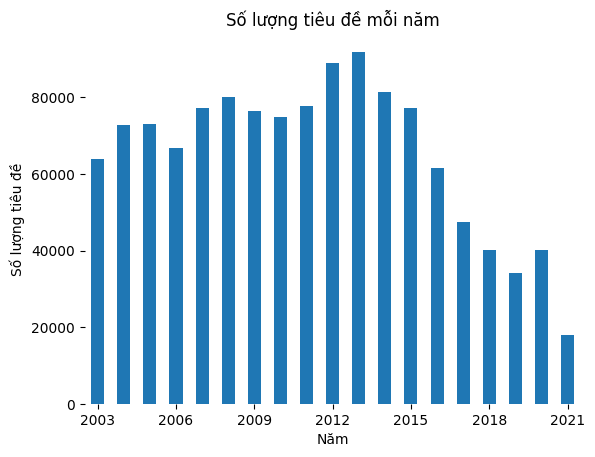

In [ ]:
df['publish_date'] = pd.to_datetime(df['publish_date'], format='%Y%m%d')

df['year'] = df['publish_date'].dt.year

headlines_per_year = df.groupby('year')['headline_text'].count()

fig, ax = plt.subplots()
headlines_per_year.plot(kind='bar', ax=ax)
ax.set_title('Số lượng tiêu đề mỗi năm')
ax.set_xlabel('Năm')
ax.set_ylabel('Số lượng tiêu đề')
ax.set_xticklabels(headlines_per_year.index, rotation=0)

if len(headlines_per_year) > 10:
    ax.set_xticks(ax.get_xticks()[::3])
for spine in ax.spines.values():
    spine.set_visible(False)
plt.show()

# Triển khai Mô hình LDA tuần tự

In [ ]:
# Tạo từ điển dựa trên cột 'tokens'
dictionary = corpora.Dictionary(df['tokens'])

# Tạo document-term matrix (corpus) dựa trên cột 'tokens'
corpus = [dictionary.doc2bow(text) for text in df['tokens']]

# Xác định số lượng chủ đề
num_topics = 20

# Xây dựng mô hình LDA
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)

In [ ]:
# Lấy phân phối chủ đề cho một văn bản cụ thể
document = df.loc[0, 'headline_text'].split()
doc_bow = dictionary.doc2bow(document)
topic_distribution = lda_model.get_document_topics(doc_bow)

In [ ]:
# In ra các chủ đề và các từ quan trọng nhất trong mỗi chủ đề
for topic_num, topic_words in lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False):
    print(f"Topic {topic_num + 1}:")
    for word, prob in topic_words:
        prob_percentage = prob * 100
        print(f"{word}: {prob_percentage:.2f}%")
    print()

Topic 1:
govern: 8.17%
china: 6.74%
border: 5.72%
death: 5.48%
die: 4.84%
attack: 3.73%
speak: 3.12%
rise: 2.73%
fear: 2.24%
reveal: 2.14%

Topic 2:
nsw: 11.48%
19: 11.44%
queensland: 8.30%
vaccin: 6.99%
day: 4.36%
bushfir: 3.89%
announc: 2.56%
make: 2.41%
presid: 1.91%
child: 1.74%

Topic 3:
polic: 12.89%
crash: 4.25%
investig: 3.47%
accus: 2.89%
royal: 2.67%
continu: 2.57%
law: 2.46%
risk: 2.30%
commiss: 2.22%
black: 2.16%

Topic 4:
year: 6.34%
man: 6.32%
record: 5.57%
court: 4.35%
charg: 4.21%
first: 3.71%
murder: 3.52%
one: 3.49%
face: 3.36%
woman: 3.07%

Topic 5:
case: 12.52%
health: 6.16%
news: 5.53%
live: 5.42%
warn: 4.31%
report: 4.19%
market: 3.46%
leader: 2.10%
shoot: 1.96%
program: 1.95%

Topic 6:
melbourn: 9.01%
minist: 5.80%
tasmania: 5.28%
show: 4.65%
island: 4.33%
uk: 4.03%
fall: 2.84%
track: 2.55%
financ: 2.54%
near: 2.45%

Topic 7:
victoria: 9.50%
nt: 5.00%
famili: 4.17%
get: 3.75%
school: 3.70%
age: 3.39%
care: 3.10%
work: 2.64%
farmer: 2.55%
million: 2.45%

Topic 8:


# Triển khai Mô hình LDA song song dùng pyspark

In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=4725f3d5c24523f6df7c2307f9c302b164b3ce68b879564f46ac3f6f881c19f8
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.clustering import LDA


In [ ]:
# Ví dụ cho việc tạo 1 session có kết nối đến master và setting cho các executor
# spark = SparkSession \
#     .builder \
#     .appName("abcNews LDA Analysis") \
#     .master("spark://MASTER_NODE_IP:PORT") \
#     .config("spark.executor.memory", "4g") \
#     .config("spark.executor.cores", "2") \
#     .config("spark.shuffle.service.enabled", "true") \
#     .config("spark.dynamicAllocation.enabled", "true") \
#     .config("spark.dynamicAllocation.initialExecutors", "2") \
#     .config("spark.dynamicAllocation.minExecutors", "1") \
#     .config("spark.dynamicAllocation.maxExecutors", "10") \
#     .getOrCreate()

In [ ]:
spark = SparkSession.builder.appName('abcNews').getOrCreate()
tokens_df = spark.createDataFrame(df)
tokens_df.show(5)

+------------+--------------------+
|publish_date|       headline_text|
+------------+--------------------+
|    20030219|aba decides again...|
|    20030219|act fire witnesse...|
|    20030219|a g calls for inf...|
|    20030219|air nz staff in a...|
|    20030219|air nz strike to ...|
+------------+--------------------+
only showing top 5 rows



In [ ]:
# Khởi tạo một đối tượng CountVectorizer với cột đầu vào là 'tokens', cột đầu ra là 'features'.
# vocabSize là số lượng từ tối đa trong từ điển. minDF là tần suất tối thiểu của một từ để được đưa vào từ điển.
cv = CountVectorizer(inputCol="tokens", outputCol="features", vocabSize=500, minDF=3.0)

# Áp dụng CountVectorizer để 'fit' dữ liệu từ DataFrame 'tokens_df', tức là học từ điển từ dữ liệu.
cv_model = cv.fit(tokens_df)

# Transform DataFrame 'tokens_df' sử dụng mô hình CountVectorizer để chuyển đổi cột 'tokens' thành cột 'features'.
# Cột 'features' sẽ chứa vector đếm số lần xuất hiện của mỗi từ trong mỗi tài liệu.
vectorized_tokens = cv_model.transform(tokens_df)

# Hiển thị 5 hàng đầu tiên của DataFrame sau khi đã áp dụng vector hóa.
vectorized_tokens.show(5)

+-------------------+--------------------+----+--------------------+--------------------+
|       publish_date|       headline_text|year|              tokens|            features|
+-------------------+--------------------+----+--------------------+--------------------+
|2003-02-19 00:00:00|aba decides again...|2003|[aba, decid, comm...|   (500,[137],[1.0])|
|2003-02-19 00:00:00|act fire witnesse...|2003|[act, fire, wit, ...|(500,[10,138],[1....|
|2003-02-19 00:00:00|a g calls for inf...|2003|[g, call, infrast...|(500,[6,369],[1.0...|
|2003-02-19 00:00:00|air nz staff in a...|2003|[air, nz, staff, ...|(500,[63,157,207,...|
|2003-02-19 00:00:00|air nz strike to ...|2003|[air, nz, strike,...|(500,[18,207,237,...|
+-------------------+--------------------+----+--------------------+--------------------+
only showing top 5 rows



In [ ]:
# Đặt số lượng chủ đề cần tìm
num_topics = 20

# Khởi tạo mô hình LDA với số lượng chủ đề (k) và số lần lặp tối đa (maxIter)
lda = LDA(k=num_topics, maxIter=50)

# Áp dụng mô hình LDA lên DataFrame đã được vector hóa để tìm các chủ đề
model = lda.fit(vectorized_tokens)

# Xuất mô hình sau khi đã được fit
model

LocalLDAModel: uid=LDA_431905f48946, k=20, numFeatures=500

In [ ]:
# Lấy vocabulary từ CountVectorizer model
vocab = cv_model.vocabulary

# Mô tả các chủ đề được tìm thấy bởi LDA model
topics = model.describeTopics()

# Chuyển đổi DataFrame của Spark thành RDD (Resilient Distributed Dataset)
# và áp dụng một hàm để lấy ra chỉ số của các thuật ngữ (term indices) cho mỗi chủ đề
# sau đó thu thập kết quả về máy local
collected_topics = topics.rdd\
    .map(lambda row: row['termIndices'])\
    .collect()

# Trích xuất và chuyển đổi các chỉ số thuật ngữ thành từ tương ứng từ vocabulary
topics_words = topics.rdd\
    .map(lambda row: row['termIndices'])\
    .map(lambda idx_list: [vocab[idx] for idx in idx_list])\
    .collect()


In [ ]:
vocab

['polic',
 'new',
 'man',
 'say',
 'plan',
 'charg',
 'call',
 'us',
 'australia',
 'council',
 'fire',
 'court',
 'govt',
 'win',
 'back',
 'nsw',
 'kill',
 'interview',
 'australian',
 'death',
 'report',
 'face',
 'crash',
 'warn',
 'fund',
 'urg',
 'sydney',
 'water',
 'get',
 'year',
 'wa',
 'attack',
 'qld',
 'murder',
 'chang',
 'take',
 'open',
 'health',
 'day',
 'hous',
 'hit',
 'mine',
 'elect',
 'jail',
 'home',
 'market',
 'miss',
 'govern',
 'claim',
 'hospit',
 'world',
 'nation',
 'car',
 'sa',
 'help',
 'school',
 'accus',
 'woman',
 'die',
 'cut',
 'test',
 'set',
 'coast',
 'rise',
 'south',
 'two',
 'may',
 'drug',
 'case',
 'ban',
 'china',
 'farmer',
 'minist',
 'found',
 'first',
 'fear',
 'job',
 'coronaviru',
 'boost',
 'talk',
 'flood',
 'servic',
 'protest',
 'final',
 'investig',
 'group',
 'mp',
 'worker',
 'melbourn',
 'road',
 'make',
 'continu',
 'north',
 'record',
 'work',
 'arrest',
 'price',
 'concern',
 'queensland',
 'power',
 'fight',
 'busi',
 'o

In [ ]:
topics

DataFrame[topic: int, termIndices: array<int>, termWeights: array<double>]

In [ ]:
collected_topics

[[140, 201, 213, 263, 180, 199, 366, 365, 458, 420],
 [31, 76, 87, 59, 99, 102, 141, 154, 65, 197],
 [42, 61, 63, 103, 137, 165, 192, 220, 236, 231],
 [8, 17, 14, 29, 40, 45, 50, 47, 104, 100],
 [35, 73, 89, 88, 133, 135, 151, 169, 72, 160],
 [18, 51, 71, 70, 77, 93, 212, 218, 179, 264],
 [23, 41, 83, 106, 210, 239, 188, 260, 285, 297],
 [15, 26, 28, 38, 95, 80, 108, 112, 68, 129],
 [22, 49, 21, 56, 24, 82, 119, 36, 122, 193],
 [46, 78, 91, 109, 94, 114, 152, 153, 168, 249],
 [75, 189, 243, 257, 300, 320, 398, 404, 383, 379],
 [86, 158, 155, 178, 219, 253, 399, 395, 436, 413],
 [4, 16, 9, 39, 62, 96, 97, 115, 134, 157],
 [0, 6, 43, 55, 84, 11, 52, 107, 120, 125],
 [3, 110, 163, 173, 252, 338, 400, 406, 416, 363],
 [34, 30, 101, 123, 131, 147, 162, 202, 254, 296],
 [2, 5, 19, 33, 48, 58, 90, 57, 113, 11],
 [12, 27, 25, 37, 66, 156, 161, 186, 191, 175],
 [7, 10, 74, 117, 92, 164, 221, 240, 228, 234],
 [1, 13, 20, 60, 81, 111, 127, 138, 145, 146]]

In [ ]:
topics_words

[['dead',
  'leav',
  'shoot',
  'season',
  'bushfir',
  'three',
  'extend',
  'nrl',
  'shot',
  'five'],
 ['attack',
  'job',
  'worker',
  'cut',
  'power',
  'one',
  'adelaid',
  'train',
  'two',
  'appeal'],
 ['elect',
  'set',
  'rise',
  'nt',
  'commun',
  'live',
  'student',
  'vote',
  'prison',
  'begin'],
 ['australia',
  'interview',
  'back',
  'year',
  'hit',
  'market',
  'world',
  'govern',
  'cup',
  'fight'],
 ['take',
  'found',
  'road',
  'melbourn',
  'abc',
  'top',
  'close',
  'still',
  'minist',
  'park'],
 ['australian',
  'nation',
  'farmer',
  'china',
  'coronaviru',
  'record',
  'victoria',
  'island',
  'trump',
  'covid'],
 ['warn',
  'mine',
  'final',
  'trial',
  'delay',
  'cost',
  'review',
  'dog',
  'peopl',
  'blaze'],
 ['nsw',
  'sydney',
  'get',
  'day',
  'arrest',
  'flood',
  'labor',
  'lead',
  'case',
  'time'],
 ['crash',
  'hospit',
  'face',
  'accus',
  'fund',
  'protest',
  'pm',
  'open',
  'end',
  'aussi'],
 ['miss'